# 🧪 HUẤN LUYỆN MÔ HÌNH DỊCH VỚI KIẾN TRÚC ViT5 (BASE & LARGE)

---

### 🎯 Mục tiêu
Notebook này mở rộng phạm vi thử nghiệm bằng cách fine-tune mô hình **ViT5** (Vietnamese Text-to-Text Transfer Transformer) để so sánh hiệu quả với BARTpho. ViT5 được biết đến với khả năng xử lý các tác vụ sinh văn bản tiếng Việt rất tốt nhờ lượng dữ liệu pre-training khổng lồ.

### ⚙️ Cấu hình Thử nghiệm
Chúng ta sẽ tiến hành huấn luyện hai phiên bản để đánh giá sự đánh đổi giữa tài nguyên và hiệu suất:
1.  **ViT5-base:** `VietAI/vit5-base` (Mô hình nhẹ, tốc độ nhanh).
2.  **ViT5-large:** `VietAI/vit5-large` (Mô hình lớn, kỳ vọng độ chính xác cao hơn).

### 📊 Dữ liệu & Phương pháp
* **Dữ liệu:** Tập `Corpus-Vie-VSL-10K` (80% Train, 10% Val, 10% Test).
* **Kỹ thuật:**
    * Sử dụng thư viện `HuggingFace Transformers`.
    * Tối ưu hóa bộ nhớ với `bitsandbytes` (8-bit optimizer) và `gradient_accumulation` cho bản Large để chạy được trên Google Colab.
    * Đánh giá bằng **BLEU** và **WER**.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cài đặt thư viện
!pip install -q transformers torch datasets accelerate gspread oauth2client pandas scikit-learn sacrebleu datasets evaluate jiwer matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.auth import default
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback
import numpy as np
import evaluate
import jiwer
import matplotlib.pyplot as plt

## Tiền xử lý dữ liệu

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/Corpus-Vie-VSL-10K.csv')

In [ ]:
print("Cột trong csv: ", df.columns.tolist())
print("Số lượng cặp: ", len(df))
print("Ví dụ 5 dòng đầu: ")
print(df.head())

Cột trong csv:  ['input_text', 'target_text']
Số lượng cặp:  10000
Ví dụ 5 dòng đầu: 
           input_text          target_text
0   vi: Tôi 19 tuổi .  vsl: ﻿Tôi tuổi 19 .
1    vi: Bạn tên gì ?    vsl: Bạn tên gì ?
2   vi: Ai biết bơi ?   vsl: Biết bơi ai ?
3  vi: Con gà ăn gì ?  vsl: Con gà ăn gì ?
4  vi: Mít thì ngọt .      vsl: Mít ngọt .


In [ ]:
# Lưu vào drive
raw_path = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/Corpus-Vie-VSL-10K.csv'
df[['input_text', 'target_text']].to_csv(raw_path, index = False)
print(f"Đã lưu raw data vào {raw_path}")

Đã lưu raw data vào /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/Corpus-Vie-VSL-10K.csv


In [ ]:
# Chia dữ liệu thành train/val/test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state = 42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state = 42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 8000, Val: 1000, Test: 1000


In [ ]:
# Chuyển sang Hugging Face Dataset
dataset ={
    'train': Dataset.from_pandas(train_df[['input_text', 'target_text']]),
    'val': Dataset.from_pandas(val_df[['input_text', 'target_text']]),
    'test': Dataset.from_pandas(test_df[['input_text', 'target_text']])
}

## Triển khai mô hình ViT5-base

In [ ]:
# Load Tokenizer và Model ViT5-base
model_name = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to('cuda')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
# Hàm Tokenize dữ liệu
def preprocess_function(examples):
  inputs = examples['input_text']
  targets = examples['target_text']

  model_inputs = tokenizer(inputs, max_length = 128, truncation = True, padding = 'max_length')

  # Tokenize targets
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, max_length = 128, truncation = True, padding = 'max_length')

  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [ ]:
# Áp dụng tokenize cho Train, Test, Val
tokenized_datasets = {
    'train': dataset['train'].map(preprocess_function, batched = True),
    'val': dataset['val'].map(preprocess_function, batched = True),
    'test': dataset['test'].map(preprocess_function, batched = True)
}

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Định nghĩa thông số huấn luyện

In [ ]:
# Định nghĩa Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_Time2/model_checkpoints',
    eval_strategy = 'epoch',
    eval_steps = 1,
    learning_rate = 5e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    weight_decay = 0.01,
    save_total_limit = 3,
    num_train_epochs = 10,
    predict_with_generate = True, # to generate text when evaluate
    fp16 = True,
    logging_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_Time2/logs',
    logging_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    report_to = 'none',
    metric_for_best_model = 'eval_loss',
    greater_is_better = False
)

### Định nghĩa hàm đánh giá bản dịch BLEU, WER

In [ ]:
# Khởi tạo bộ tính toán bleu và wer
bleu_metric = evaluate.load('sacrebleu')
wer_metric = evaluate.load('wer')

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # In một vài giá trị preds để kiểm tra
    print("Sample preds: ", preds[:2]) # Lấy 2 mẫu đầu tiên

    # Làm sạch preds: Loại bỏ token IDs không hợp lệ
    vocab_size = tokenizer.vocab_size
    preds = np.where(preds < 0, tokenizer.pad_token_id, preds)
    preds = np.where(preds >= vocab_size, tokenizer.pad_token_id, preds)

    # Decode generated texts
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in labels (ignored tokens)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Chuẩn hóa text cho WER (loại bỏ dấu thừa, chuyển về lowercase)
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Compute BLEU
    bleu = bleu_metric.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])

    # Compute WER
    wer = jiwer.wer(decoded_labels, decoded_preds)

    return {
        "bleu": bleu["score"],
        "wer": wer
    }

In [ ]:
# Tránh token IDs không hợp lệ, cấu hình tham số generate
gen_kwargs = {
    'max_length': 128,
    'num_beams': 4,
    'no_repeat_ngram_size': 2
}

### Trainning Process

In [ ]:
# Tạo Trainer
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)]
)

/tmp/ipython-input-2948321485.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Huấn luyện Model
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Wer
1,0.437800,0.005644,95.932378,0.029361
2,0.004900,0.005369,96.923956,0.023812
3,0.002900,0.004926,97.186634,0.021038
4,0.002000,0.005740,97.254673,0.021616
5,0.001300,0.006155,97.171006,0.021847
6,0.000900,0.006329,97.419450,0.021269


Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0  -100]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0  -100]]


Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0     0]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0     0]]
Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0  -100]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0  -100]]


Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0     0]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0     0]]
Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0     0]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0     0]]


Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0     0]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0     0]]


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=3000, training_loss=0.07496211325128874, metrics={'train_runtime': 1583.392, 'train_samples_per_second': 50.524, 'train_steps_per_second': 3.158, 'total_flos': 7307494686720000.0, 'train_loss': 0.07496211325128874, 'epoch': 6.0})

In [ ]:
# Evaluating
test_results = trainer.evaluate(eval_dataset = tokenized_datasets['test'], **gen_kwargs)
print("Kết quả đánh giá trên test set: ", test_results)

Sample preds:  [[    0    11 11380 35862  3307  1708   884   398  1670  1031   464   642
      6     1     1     1     1     1     1     1     1     1  -100  -100
   -100  -100  -100  -100  -100  -100  -100]
 [    0    11 11380 35862   432    49  1036   842   250   738   898     6
      1     1     1     1     1     1     1     1     1     1  -100  -100
   -100  -100  -100  -100  -100  -100  -100]]


Kết quả đánh giá trên test set:  {'eval_loss': 0.006086297798901796, 'eval_bleu': 97.23450572260558, 'eval_wer': 0.01669545192861255, 'eval_runtime': 60.9698, 'eval_samples_per_second': 16.402, 'eval_steps_per_second': 1.033, 'epoch': 6.0}


In [ ]:
# Vẽ đồ thị Training Loss và Validation Loss

In [ ]:
!pip install -q matplotlib

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Lấy log_history từ trainer.state
log_history = trainer.state.log_history

# Chuyển log_history thành DataFrame cho dễ xử lý
df_logs = pd.DataFrame(log_history)

# Tách log của training và evaluation
train_logs = df_logs[df_logs['loss'].notna()].reset_index(drop = True)
eval_logs = df_logs[df_logs['eval_loss'].notna()].reset_index(drop = True)

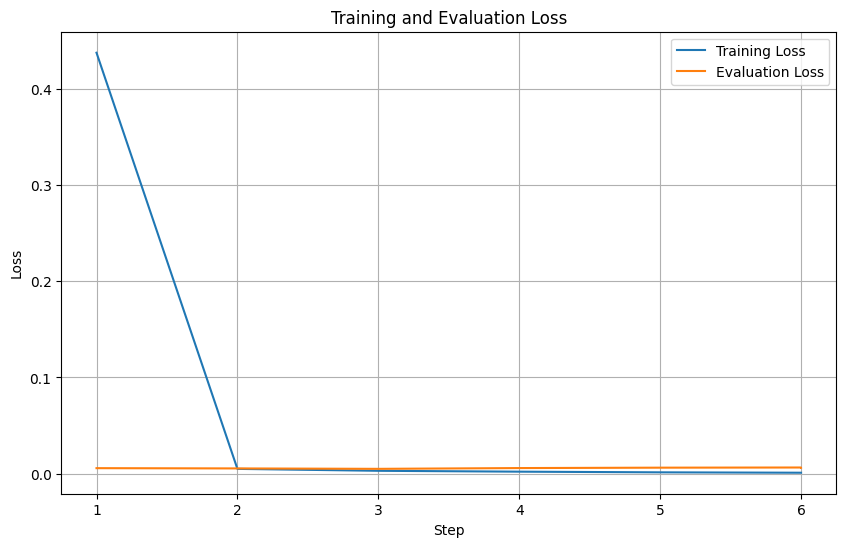

In [ ]:
# Vẽ đồ thị
plt.figure(figsize = (10, 6))
plt.plot(train_logs['epoch'], train_logs['loss'], label = 'Training Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label = 'Evaluation Loss')
plt.title('Training and Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 7. Lưu Model vào Drive
output_model_dir = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_Time2/trained_model"
model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)
print(f"Model saved to {output_model_dir}")

Model saved to /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_Time2/trained_model


In [ ]:
# Sử dụng model để thử dịch 2 câu tiếng Việt sang ngôn ngữ ký hiệu
# Câu tiếng Việt muốn dịch
sentence_to_translate = "Tôi muốn một ly cà phê đen, ít đường thôi."
prefix = "vsl:"
input_text = f"{prefix} {sentence_to_translate}"
print(f"Câu cần dịch: {input_text}")
inputs = tokenizer(input_text, return_tensors="pt").to('cuda')

Câu cần dịch: vsl: Tôi muốn một ly cà phê đen, ít đường thôi.


In [ ]:
with torch.no_grad():
    output_ids = model.generate(
        inputs["input_ids"],
        max_length=128,          # Độ dài tối đa của câu kết quả
        num_beams=5,             # Sử dụng beam search để kết quả tốt và mượt mà hơn
        early_stopping=True
    )

In [ ]:
# Giải mã
translated_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [ ]:
# In kết quả
print(f"Câu tiếng Việt gốc:\n'{sentence_to_translate}'")
print(f"\nNgôn ngữ ký hiệu:\n'{translated_sentence}'")

Câu tiếng Việt gốc:
'Tôi muốn một ly cà phê đen, ít đường thôi.'

Ngôn ngữ ký hiệu:
'vsl: Tôi muốn một ly cà phê đen ít đường thôi .'


### Điều chỉnh đồ thị

In [ ]:
!pip install pandas matplotlib

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

## Triển khai mô hình ViT5-large

In [ ]:
# Load Tokenizer và Model ViT5-large
model_name = "VietAI/vit5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to('cuda')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.17G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.17G [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(36100, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36100, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [ ]:
# Hàm Tokenize dữ liệu
def preprocess_function(examples):
  inputs = examples['input_text']
  targets = examples['target_text']

  model_inputs = tokenizer(inputs, max_length = 128, truncation = True, padding = 'max_length')

  # Tokenize targets
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, max_length = 128, truncation = True, padding = 'max_length')

  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [ ]:
# Áp dụng tokenize cho Train, Test, Val
tokenized_datasets = {
    'train': dataset['train'].map(preprocess_function, batched = True),
    'val': dataset['val'].map(preprocess_function, batched = True),
    'test': dataset['test'].map(preprocess_function, batched = True)
}

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Định nghĩa thông số huấn luyện

In [ ]:
!pip install -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 1.7 MB/s eta 0:00:00


In [ ]:
# Định nghĩa Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_large_Time2/model_checkpoints',
    eval_strategy = 'epoch',
    learning_rate = 5e-5,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    gradient_accumulation_steps = 4,
    optim = 'adamw_8bit',
    gradient_checkpointing = True,
    weight_decay = 0.01,
    save_total_limit = 3,
    num_train_epochs = 10,
    predict_with_generate = True, # to generate text when evaluate
    fp16 = True,
    logging_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_large/logs',
    logging_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    report_to = 'none',
    metric_for_best_model = 'eval_loss',
    greater_is_better = False
)

### Định nghĩa hàm đánh giá BLEU, WER

In [ ]:
# Khởi tạo bộ tính toán bleu và wer
bleu_metric = evaluate.load('sacrebleu')
wer_metric = evaluate.load('wer')

In [ ]:
# Xây dựng hàm đánh giá
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # In một vài giá trị preds để kiểm tra
    print("Sample preds: ", preds[:2]) # Lấy 2 mẫu đầu tiên

    # Làm sạch preds: Loại bỏ token IDs không hợp lệ
    vocab_size = tokenizer.vocab_size
    preds = np.where(preds < 0, tokenizer.pad_token_id, preds)
    preds = np.where(preds >= vocab_size, tokenizer.pad_token_id, preds)

    # Decode generated texts
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in labels (ignored tokens)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Chuẩn hóa text cho WER (loại bỏ dấu thừa, chuyển về lowercase)
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Compute BLEU
    bleu = bleu_metric.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])

    # Compute WER
    wer = jiwer.wer(decoded_labels, decoded_preds)

    return {
        "bleu": bleu["score"],
        "wer": wer
    }

In [ ]:
# Tránh token IDs không hợp lệ, cấu hình tham số generate
gen_kwargs = {
    'max_length': 128,
    'num_beams': 4,
    'no_repeat_ngram_size': 2
}

### Training Process

In [ ]:
# Creating Trainer
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)]
)

/tmp/ipython-input-3071698283.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Training Model
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Bleu,Wer
1,3.082600,0.007005,95.521258,0.036181
2,0.005600,0.005346,96.611533,0.024853
3,0.002600,0.006322,97.205838,0.021847
4,0.001900,0.005945,97.315309,0.021385
5,0.001200,0.007064,97.118935,0.022078


Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0  -100]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0  -100]]


Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0  -100]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0  -100]]


Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0  -100]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0  -100]]


Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0  -100]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0  -100]]


Sample preds:  [[    0    11 11380 35862  2586   671   979  1246  2097  9321  1359    74
    129   442     1     0     0     0     0     0  -100]
 [    0    11 11380 35862   188  1193   235   162  1379   433   198  2679
      6     1     0     0     0     0     0     0  -100]]


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=2500, training_loss=0.6187780540943145, metrics={'train_runtime': 8147.9377, 'train_samples_per_second': 9.818, 'train_steps_per_second': 0.614, 'total_flos': 2.317262782464e+16, 'train_loss': 0.6187780540943145, 'epoch': 5.0})

In [ ]:
# Evaluating
test_results = trainer.evaluate(eval_dataset = tokenized_datasets['test'], **gen_kwargs)
print("Kết quả đánh giá trên test set: ", test_results)

Sample preds:  [[    0    11 11380 35862  3307  1708   884   398  1670  1031   464   642
      6     1     0     0     0     0     0     0  -100  -100  -100  -100
   -100  -100  -100  -100  -100  -100  -100]
 [    0    11 11380 35862   432    49  1036   842   250   738   898     6
      1     1     0     0     0     0     0     0  -100  -100  -100  -100
   -100  -100  -100  -100  -100  -100  -100]]


Kết quả đánh giá trên test set:  {'eval_loss': 0.006217665504664183, 'eval_bleu': 96.87803036503037, 'eval_wer': 0.01911341393206678, 'eval_runtime': 294.3033, 'eval_samples_per_second': 3.398, 'eval_steps_per_second': 0.849, 'epoch': 5.0}


In [ ]:
# THAY ĐỔI SỐ `2500` BÊN DƯỚI cho đúng với checkpoint cuối cùng của bạn
checkpoint_step = 2500
log_file_path = f'/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_large/model_checkpoints/checkpoint-{checkpoint_step}/trainer_state.json'

# Mở và đọc file json
with open(log_file_path, 'r') as f:
    trainer_state = json.load(f)

In [ ]:
# Lấy log_history từ dữ liệu đã đọc
log_history = trainer_state['log_history']


# --- SỬ DỤNG LẠI CODE CỦA BẠN ĐỂ XỬ LÝ VÀ VẼ ---
# Chuyển log_history thành DataFrame cho dễ xử lý
df_logs = pd.DataFrame(log_history)

# Tách log của training và evaluation
train_logs = df_logs[df_logs['loss'].notna()].reset_index(drop=True)
eval_logs = df_logs[df_logs['eval_loss'].notna()].reset_index(drop=True)

NameError: name 'trainer_state' is not defined

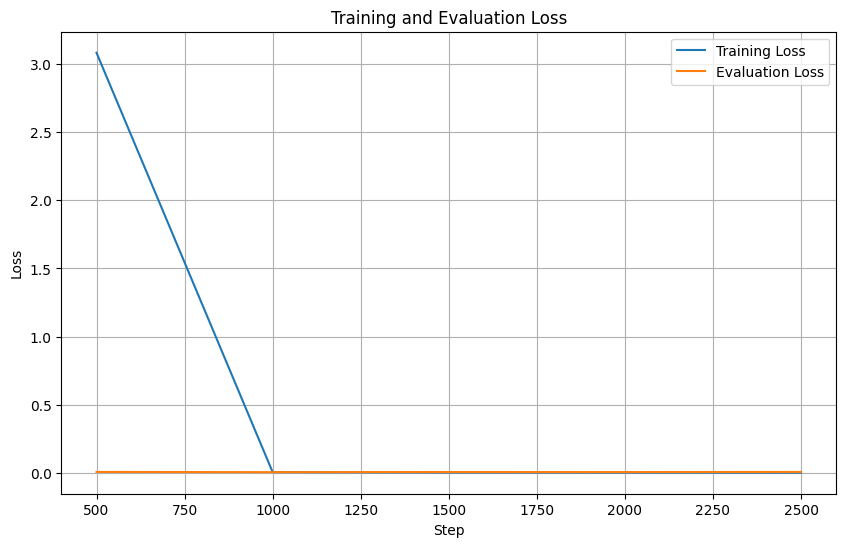

In [ ]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss')
# Lưu ý: cột loss của evaluation trong dataframe của bạn tên là 'eval_loss'
plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Evaluation Loss')
plt.title('Training and Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
#plt.ylim(0, 0.05)
plt.show()

In [ ]:
# Lấy log_history từ trainer.state
log_history = trainer.state.log_history

# Chuyển log_history thành DataFrame cho dễ xử lý
df_logs = pd.DataFrame(log_history)

# Tách log của training và evaluation
train_logs = df_logs[df_logs['loss'].notna()].reset_index(drop = True)
eval_logs = df_logs[df_logs['eval_loss'].notna()].reset_index(drop = True)

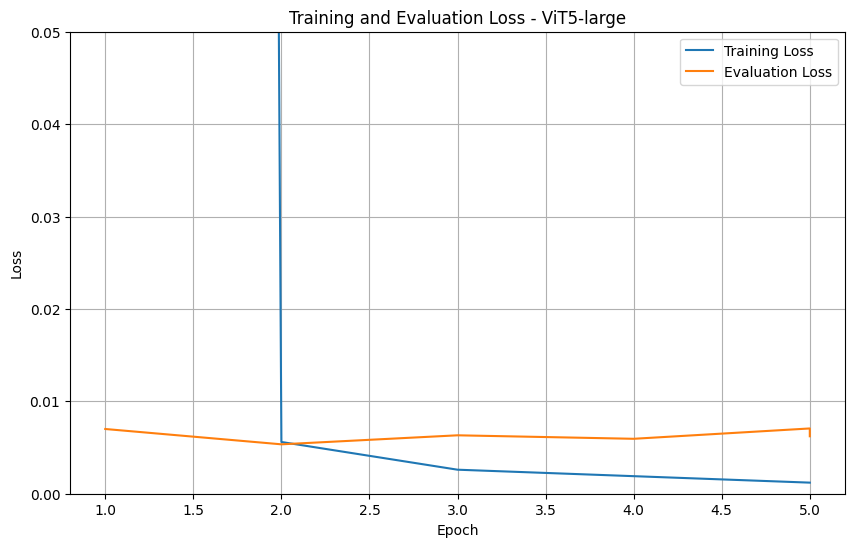

In [ ]:
# Vẽ đồ thị
plt.figure(figsize = (10, 6))
plt.plot(train_logs['epoch'], train_logs['loss'], label = 'Training Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label = 'Evaluation Loss')
plt.title('Training and Evaluation Loss - ViT5-large')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 0.05)
plt.show()

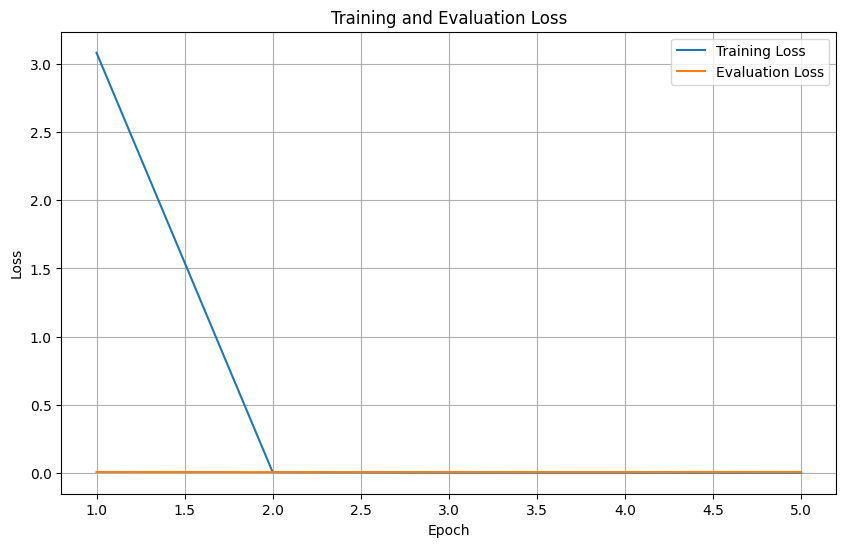

In [ ]:
# Vẽ đồ thị
plt.figure(figsize = (10, 6))
plt.plot(train_logs['epoch'], train_logs['loss'], label = 'Training Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label = 'Evaluation Loss')
plt.title('Training and Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 7. Lưu Model vào Drive
output_model_dir = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5-large_Time2/trained_model"
model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)
print(f"Model saved to {output_model_dir}")

Model saved to /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5-large_Time2/trained_model


In [ ]:
# Sử dụng model để thử dịch 2 câu tiếng Việt sang ngôn ngữ ký hiệu
# Câu tiếng Việt muốn dịch
sentence_to_translate = "Tôi muốn một ly cà phê đen, ít đường thôi."
prefix = "vsl:"
input_text = f"{prefix} {sentence_to_translate}"
print(f"Câu cần dịch: {input_text}")
inputs = tokenizer(input_text, return_tensors="pt").to('cuda')

Câu cần dịch: vsl: Tôi muốn một ly cà phê đen, ít đường thôi.


In [ ]:
with torch.no_grad():
    output_ids = model.generate(
        inputs["input_ids"],
        max_length=128,          # Độ dài tối đa của câu kết quả
        num_beams=5,             # Sử dụng beam search để kết quả tốt và mượt mà hơn
        early_stopping=True
    )

In [ ]:
# Giải mã
translated_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [ ]:
print(sentence_to_translate)
print(translated_sentence)

Tôi muốn một ly cà phê đen, ít đường thôi.
: Tôi muốn một ly cà phê đen ít đường thôi .
